# **Ocean Mixing Story Group 1**

## Background 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

## How good are these methods? 

This project has two goals:
**Determine the statistical confidance and variability of the pCO₂ reconstructions across the globe** 
**Investigate how adding more observations affects statistical confidence and variability**

Results from this investigation will help answer whether adding data will improve the confidence of the models generally. Going a step deeper, this investigation can give insight into whether it is more important to add more observations in locations historically sampled, or in locations not in the database. Relatedly, this research can inform which areas of the globe are most important to direct funding towards sampling, or to focus other statistical technique to improve model confidence. 

By gaining more confidence in pCO2 reconstructions, scientists can more accurately answer questions related to carbon budgets and other scientific and socio-economic questions related to climate change. 

## Information about the ML model used

## Information about Adding Observations

In section 2, there is an investigation of how adding data to the model affects statistical confidence and variability. In particular, we investigate adding data across 2 dimensions:

1. Adding more observations at locations that have historically been sampled. 
2. Adding new locations, not previously sampled for pCO2 concentrations.

For adding more observations to locations that have historically been sampled, chose to do XXXX(add later depending on what works)

In particular, this research will focus on adding samples to 4 Ocean Basins undersampled in the research: Southern Ocean, Indian Ocean, Arctic Areas, and Pacific Ocean between Australia and South America.  

In [2]:
your_username = 'azamkhan99'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'azamkhan99'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [3]:
%%capture
!pip install tensorflow
!pip install keras

In [4]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


In [5]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

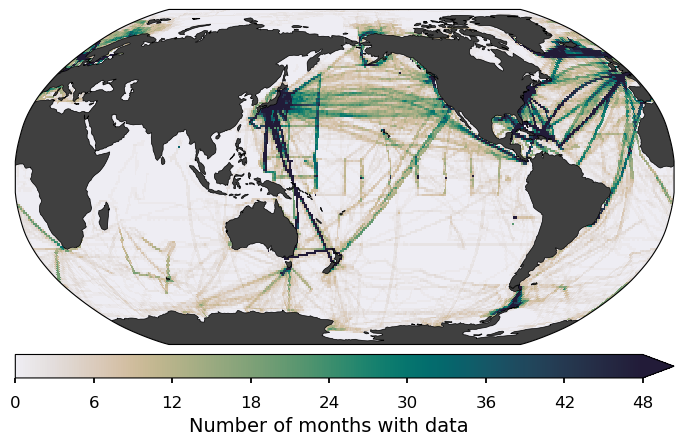

In [6]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [7]:
#socat_mask_data.where(non_zero_counts == 0, socat_mask_data.max(dim='ylat'))
indices = non_zero_counts.where(non_zero_counts == 5).coords
index_list = list(zip(indices['xlon'].values, indices['ylat'].values))
#print(index_list[0])
#-179.5, -89.5
index_list[50][1]
#non_zero_counts.sel(xlon = -179.5, ylat = -89.5).values
test = non_zero_counts.where(non_zero_counts == 5)
test[14][7]

socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

<bound method Mapping.values of <xarray.Dataset> Size: 4kB
Dimensions:     (time: 240)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
    xlon        float64 8B -172.5
    ylat        float64 8B -75.5
Data variables:
    socat_mask  (time) float64 2kB dask.array<chunksize=(52,), meta=np.ndarray>>

In [8]:
socat_mask_data

<xarray.Dataset> Size: 124MB
Dimensions:     (time: 240, ylat: 180, xlon: 360)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon        (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    socat_mask  (time, ylat, xlon) float64 124MB dask.array<chunksize=(52, 45, 90), meta=np.ndarray>

In [9]:
#non_zero_counts.sum().item()
#287,121 instances
socat_mask_data.sum()

<xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    socat_mask  float64 8B dask.array<chunksize=(), meta=np.ndarray>

In [10]:
#if there's real world data sampled at the location, say it's sampled more
#no change in distribution of sampling
mean_val_glob_loc = non_zero_counts.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), 5)
socat_mean_glob = socat_mask_data.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), socat_mask_data.sel(xlon = -172.5, ylat = -75.5))

thirtyp_val_glob  = non_zero_counts.where((non_zero_counts > 7)|(non_zero_counts == 0), 7)
socat_30p_glob = socat_mask_data.where((non_zero_counts > 7)|(non_zero_counts == 0), socat_mask_data.where(non_zero_counts == 7))
fiftyp_val_glob = non_zero_counts.where((non_zero_counts > 10)|(non_zero_counts == 0), 10)
socat_50p_glob = socat_mask_data.where((non_zero_counts > 9)|(non_zero_counts == 0), socat_mask_data.where(non_zero_counts == 9))

In [11]:
# helper ----------------------------------------------------------
def _stamp_region(ocean_da, socat_ds, lat1, lat2, lon1, lon2, val):
    """
    Fill a rectangular lat/lon window of `ocean_da` with `val`
    and copy the corresponding slice of the original SOCAT mask
    into the same window of `socat_ds['socat_mask']`.

    All inputs are **coordinate labels** (°), not integer indices.
    """
    # always build ascending slices for .loc
    lat_slice = slice(min(lat1, lat2), max(lat1, lat2))
    lon_slice = slice(min(lon1, lon2), max(lon1, lon2))

    ocean_da.loc[dict(ylat=lat_slice, xlon=lon_slice)] = val

    socat_ds["socat_mask"].loc[dict(ylat=lat_slice, xlon=lon_slice)] = (
        socat_mask_data["socat_mask"]  # original mask
        .loc[dict(ylat=lat_slice, xlon=lon_slice)]
        .where(non_zero_counts == val)  # keep dtype / nans consistent
    )


# -----------------------------------------------------------------
# 14 % scenario ----------------------------------------------------
add14p_oceans = non_zero_counts.copy()
add14p_socat = socat_mask_data.copy()

_stamp_region(add14p_oceans, add14p_socat, -46, -36, -97, -87, 34)  # Pacific‑1
_stamp_region(add14p_oceans, add14p_socat, -45, -35, -130, -110, 34)  # Pacific‑2
_stamp_region(add14p_oceans, add14p_socat, -32, -27, -141, -121, 34)  # Pacific‑3
_stamp_region(add14p_oceans, add14p_socat, -90, -70, 90, 110, 34)  # Southern Ocean
_stamp_region(add14p_oceans, add14p_socat, -11, 9, 75, 85, 33)  # Indian‑1
_stamp_region(add14p_oceans, add14p_socat, -30, -25, 70, 90, 33)  # Indian‑2

# 30 % scenario ----------------------------------------------------
add30p_oceans = non_zero_counts.copy()
add30p_socat = socat_mask_data.copy()

_stamp_region(add30p_oceans, add30p_socat, -46, -36, -97, -87, 73)
_stamp_region(add30p_oceans, add30p_socat, -45, -35, -130, -110, 73)
_stamp_region(add30p_oceans, add30p_socat, -32, -27, -141, -121, 73)
_stamp_region(add30p_oceans, add30p_socat, -90, -70, 90, 110, 73)
_stamp_region(add30p_oceans, add30p_socat, -11, 9, 75, 85, 72)
_stamp_region(add30p_oceans, add30p_socat, -30, -25, 70, 90, 72)

# 52 % scenario ----------------------------------------------------
add52p_oceans = non_zero_counts.copy()
add52p_socat = socat_mask_data.copy()

_stamp_region(add52p_oceans, add52p_socat, -46, -36, -97, -87, 125)
_stamp_region(add52p_oceans, add52p_socat, -45, -35, -130, -110, 125)
_stamp_region(add52p_oceans, add52p_socat, -32, -27, -141, -121, 125)
_stamp_region(add52p_oceans, add52p_socat, -90, -70, 90, 110, 125)
_stamp_region(add52p_oceans, add52p_socat, -11, 9, 75, 85, 125)
_stamp_region(add52p_oceans, add52p_socat, -30, -25, 70, 90, 125)


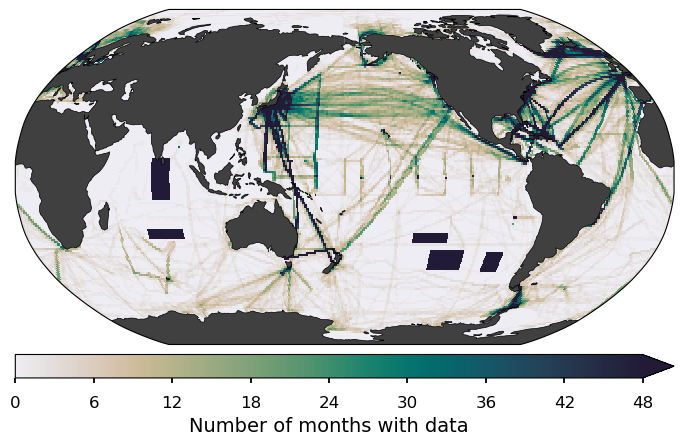

In [12]:
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(add52p_oceans, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [13]:
##Will take this out, but checking for 
#Pzeros = pacific.where(pacific ==0)
#pacific25 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-31))
#pacific50 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-36))
#pacific100 = non_zero_counts.sel(xlon=slice(-97,-87),ylat=slice(-46,-36))
#southern25 = non_zero_counts.sel(xlon=slice(105,110),ylat=slice(-80,-75))
#southern50 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-75))
#southern100 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-70))

#indian25 = non_zero_counts.sel(xlon=slice(75,80),ylat=slice(-10,-5))
#indian50 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,-5))
#indian100 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,0))

#arctic100 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(50,60))
#arctic50 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(55,60))
#arctic25 = non_zero_counts.sel(xlon=slice(-75,-70),ylat=slice(55,60))

#non_zero_counts.sel(xlon=slice(90,110),ylat=slice(55,75)).values

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Region</th>
    <th style="border: 1px solid black;">Latitude Range</th>
    <th style="border: 1px solid black;">Longitude Range</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 1</td>
    <td style="border: 1px solid black;">-46 to -36</td>
    <td style="border: 1px solid black;">-97 to -87</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 2</td>
    <td style="border: 1px solid black;">-45 to -35</td>
    <td style="border: 1px solid black;">-130 to -110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 3</td>
    <td style="border: 1px solid black;">-32 to -27</td>
    <td style="border: 1px solid black;">-141 to -121</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Southern Ocean</td>
    <td style="border: 1px solid black;">-90 to -70</td>
    <td style="border: 1px solid black;">90 to 110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 1</td>
    <td style="border: 1px solid black;">-11 to 9</td>
    <td style="border: 1px solid black;">75 to 85</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 2</td>
    <td style="border: 1px solid black;">-30 to -25</td>
    <td style="border: 1px solid black;">70 to 90</td>
  </tr>
</table>



## SOCAT Sampling Mask Variants

This notebook investigates how different sampling strategies affect the statistical confidence of pCO₂ reconstructions. The following variants of the SOCAT mask are used:

---

### 🔹 Original Mask

- **`socat_mask_data`**  
  The baseline SOCAT sampling mask, showing where and when surface ocean pCO₂ has been measured.

---

### 🔸 Augmenting Existing Sampled Locations

These variants **increase the number of samples at already-sampled locations** without changing the spatial coverage.

- **`socat_mean_glob`**  
  Boosts under-sampled locations (below global mean) to the global mean number of sampling months.

- **`socat_30p_glob`**  
  Ensures all existing sampled grid cells have at least 7 months of data (≈30% increase).

- **`socat_50p_glob`**  
  Ensures all existing sampled grid cells have at least 10 months of data (≈50% increase).

---

### 🔸 Adding New Sample Locations

These variants **expand the spatial footprint** by adding sampling at new locations in undersampled ocean regions.

- **`addmeanp_socat`**  
  Adds ~14% new grid points in each of the three undersampled basins, sampled at the global mean frequency.

- **`add30p_socat`**  
  Adds 100 new grid points per basin, each with moderate sampling (~7 months).

- **`add50p_socat`**  
  Adds 200 new grid points per basin, each with higher sampling (~10 months).

---

In [14]:
mask_data_dict = {
    "baseline": socat_mask_data,
    "densify_mean_pattern": socat_mean_glob,
    "densify_30p": socat_30p_glob,
    "densify_50p": socat_50p_glob,
    "expand_14p": add14p_socat,
    "expand_30p": add30p_socat,
    "expand_52p": add52p_socat,
}


In [15]:
non_zero_dict = {
    "baseline" : non_zero_counts,
    "densify_mean_pattern": mean_val_glob_loc,
    "densify_30p": thirtyp_val_glob,
    "densify_50p": fiftyp_val_glob,
    "expand_14p": add14p_oceans,
    "expand_30p": add30p_oceans,
    "expand_52p": add52p_oceans
    
}

In [16]:
%%capture
!pip install --upgrade ngboost

In [70]:
def apply_socat_mask_inplace(df: pd.DataFrame, mask_dataset: xr.Dataset) -> None:
    """
    Fast in-place assignment of 'socat_mask' from an xarray.Dataset to a DataFrame with MultiIndex (time, ylat, xlon).

    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex (time, ylat, xlon)
        mask_dataset (xr.Dataset): xarray dataset containing 'socat_mask' with dims (time, ylat, xlon)

    Returns:
        None (modifies df in-place)
    """
    time = df.index.get_level_values("time").values
    ylat = df.index.get_level_values("ylat").astype(float).values
    xlon = df.index.get_level_values("xlon").astype(float).values

    mask_da = mask_dataset["socat_mask"]
    mask_vals = mask_da.sel(
        time=xr.DataArray(time, dims="points"),
        ylat=xr.DataArray(ylat, dims="points"),
        xlon=xr.DataArray(xlon, dims="points"),
        method="nearest",
    ).values

    if hasattr(mask_vals, "compute"):
        mask_vals = mask_vals.compute()

    df["socat_mask"] = mask_vals


In [71]:
from collections import defaultdict
import pandas as pd
import numpy as np
import datetime
import csv
from ngboost import NGBRegressor
from ngboost.distns import Normal
import gcsfs
import lib.residual_utils as supporting_functions

def run_ngboost_with_masks(
    mask_data_dict,
    selected_mems_dict,
    features_sel,
    target_sel,
    year_mon,
    test_year_mon,
    path_seeds,
    MLinputs_path,
    init_date,
    fin_date,
    metrics_output_dir,
    test_perform_fname,
    params,
    runthiscell=-1,
):
    fs = gcsfs.GCSFileSystem()
    if runthiscell:
        random_seeds = np.load(fs.open(path_seeds))
    seed_loc_dict = defaultdict(dict)
    for ens, mem_list in selected_mems_dict.items():
        sub_dictt = {mem: no for no, mem in enumerate(mem_list)}
        seed_loc_dict[ens] = sub_dictt

    val_prop = 0.2
    test_prop = 0.0

    print(datetime.datetime.now())

    if runthiscell == -1:
        print(
            "Reviewing process: Running ML only for the first member of the first ESM."
        )
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict

    for mask_name, mask_data in mask_data_dict.items():
        print(f"\nRunning NGBoost for mask: {mask_name}\n")

        for ens, mem_list in run_selected_mems_dict.items():
            for member in mem_list:
                print(ens, member)
                seed_loc = seed_loc_dict[ens][member]
                data_dir = f"{MLinputs_path}/{ens}/{member}"
                fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
                file_path = f"{data_dir}/{fname}"

                with fs.open(file_path, "rb") as filee:
                    df = pd.read_pickle(filee)
                    df["year"] = df.index.get_level_values("time").year
                    df["mon"] = df.index.get_level_values("time").month
                    df["year_month"] = (
                        df["year"].astype(str) + "-" + df["mon"].astype(str)
                    )

                    # Replace socat_mask with the new mask
                    apply_socat_mask_inplace(df, mask_data)
                    print("Applied new SOCAT mask")

                    recon_sel = (
                        ~df[features_sel + target_sel + ["net_mask"]].isna().any(axis=1)
                    ) & (
                        (df[target_sel] < 250) & (df[target_sel] > -250)
                    ).to_numpy().ravel()

                    sel = recon_sel & (df["socat_mask"] == 1)

                    train_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    test_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(test_year_mon)))
                        .to_numpy()
                        .ravel()
                    )

                    X = df.loc[sel, features_sel].to_numpy()
                    y = df.loc[sel, target_sel].to_numpy().ravel()
                    Xtrain = df.loc[train_sel, features_sel].to_numpy()
                    ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
                    X_test = df.loc[test_sel, features_sel].to_numpy()
                    y_test = df.loc[test_sel, target_sel].to_numpy().ravel()

                    N = Xtrain.shape[0]
                    train_val_idx, train_idx, val_idx, test_idx = (
                        supporting_functions.train_val_test_split(
                            N, test_prop, val_prop, random_seeds, seed_loc
                        )
                    )

                    (
                        X_train_val,
                        X_train,
                        X_val,
                        X_test_tmp,
                        y_train_val,
                        y_train,
                        y_val,
                        y_test_tmp,
                    ) = supporting_functions.apply_splits(
                        Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx
                    )

                model = NGBRegressor(
                    Dist=Normal, random_state=random_seeds[5, seed_loc], **params
                )
                model.fit(X_train_val, y_train_val, X_val=X_val, Y_val=y_val)

                y_pred_test = model.predict(X_test)
                pred_dist = model.pred_dist(X_test)

                pred_dist_dict = {
                    "mean_preds": pred_dist.loc,
                    "std_preds": pred_dist.scale,
                }

                test_performance = supporting_functions.evaluate_test(
                    y_test, y_pred_test
                )

                # Save prediction distribution
                rows = [
                    {
                        "ensemble": ens,
                        "member": member,
                        "index": i,
                        "mean_pred": pred_dist_dict["mean_preds"][i],
                        "std_pred": pred_dist_dict["std_preds"][i],
                        "mask": mask_name,
                    }
                    for i in range(len(pred_dist_dict["mean_preds"]))
                ]

                df_out = pd.DataFrame(rows)
                test_dist_fname = f"{metrics_output_dir}/ngb_test_dists_{mask_name}_{init_date}-{fin_date}.csv"
                print("Saving test distribution to", test_dist_fname)
                df_out.to_csv(test_dist_fname, index=False)

                # Save evaluation metrics
                test_row_dict = {"model": ens, "member": member, "mask": mask_name}
                test_row_dict.update(test_performance)
                

                file_exists = fs.exists(test_perform_fname)
                with fs.open(test_perform_fname, "a") as f_object:
                    writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                    if not file_exists:
                        writer.writeheader()
                    writer.writerow(test_row_dict)

                print(f"Test metrics for {mask_name}:", test_performance)

        print(f"Done with mask: {mask_name} at", datetime.datetime.now())


In [18]:
# features for ML:
features_sel = [
    "sst",
    "sst_anom",
    "sss",
    "sss_anom",
    "mld_clim_log",
    "chl_log",
    "chl_log_anom",
    "xco2",
    "A",
    "B",
    "C",
    "T0",
    "T1",
]

# the target variable we reconstruct:
target_sel = [
    "pco2_residual"
]  # this represents pCO2 - pCO2-T (calculated in notebook 00)


In [19]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0, len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])  ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i])  ### 20% test days set ###

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0, len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")

test_year_mon = []

for i in range(0, len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")


In [20]:
path_seeds = (
    "gs://leap-persistent/abbysh/pickles/random_seeds.npy"  # random seeds for ML
)
grid_search_approach = "nmse"
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"
output_dir = f"gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
metrics_output_dir = f"{output_dir}/metrics"  # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/ngb_test_performance_{init_date}-{fin_date}.csv"  # path for test performance metrics

In [ ]:
ngb_params = {
    "n_estimators": 500,  # Number of boosting rounds
    "learning_rate": 0.05,  # Learning rate
    "natural_gradient": True,  # Use natural gradient
    "minibatch_frac": 0.8,  # Proportion of data used per iteration
    "col_sample": 0.8,  # Feature proportion per tree
    "verbose": False,  # Disable training output
    "Score": LogScore,  # Loss function
}


In [22]:
selected_mems_dict_no_mpi = {
    "ACCESS-ESM1-5": ["member_r10i1p1f1", "member_r5i1p1f1", "member_r2i1p1f1"],
    "CanESM5": ["member_r2i1p1f1", "member_r1i1p2f1", "member_r1i1p1f1"],
}


In [23]:
selected_mems_dict_one = {
    "ACCESS-ESM1-5": ["member_r10i1p1f1"],
}

In [24]:
mask_data_dict_one = {
    "expand_14p": add14p_socat,
    
}


In [ ]:
# Call the function
run_ngboost_with_masks(
    mask_data_dict=mask_data_dict_one,
    selected_mems_dict=selected_mems_dict_one,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    path_seeds=path_seeds,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    metrics_output_dir=metrics_output_dir,
    test_perform_fname=test_perform_fname,
    params=ngb_params,  # NGBoost parameters
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
)


2025-04-22 20:13:36.477551
Reviewing process: Running ML only for the first member of the first ESM.

Running NGBoost for mask: expand_14p

ACCESS-ESM1-5 member_r10i1p1f1
Applied new SOCAT mask
Using passed validation data to check for early stopping.
[iter 0] loss=4.7312 val_loss=4.6903 scale=1.0000 norm=19.6102
[iter 100] loss=3.9478 val_loss=3.9450 scale=1.0000 norm=11.5010
[iter 200] loss=3.7681 val_loss=3.7664 scale=1.0000 norm=9.5417
[iter 300] loss=3.6802 val_loss=3.6801 scale=1.0000 norm=8.7236
[iter 400] loss=3.6229 val_loss=3.6244 scale=1.0000 norm=8.2421
Saving test distribution to gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/metrics/ngb_test_dists_expand_14p_200401-202312.csv
Test metrics for expand_14p: {'mse': 143.56853737718527, 'mae': 8.25093126378552, 'medae': np.float64(5.874551621240137), 'max_error': np.float64(185.95909738556148), 'bias': np.float64(-0.24833143746436193), 'r2': 0.7752869260698321, 'corr': np.float64(0.8818739711470232), 